In [1]:
import uproot
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import yahist

from utils.file_info import parse

In [2]:
CEPH_DIR = "/ceph/cms/store/user/jguiang/VBSWHSignalGeneration/v2/"
YEAR = "RunIISummer20UL18"
NEG_FILENAME = f"{CEPH_DIR}/VBSWH_negLambdaWZ_kWkZscan_m2to2_Mjj100toInf_TuneCP5_{YEAR}-106X_privateMC_NANOGEN_v2/merged.root"
POS_FILENAME = f"{CEPH_DIR}/VBSWH_posLambdaWZ_kWkZscan_m2to2_Mjj100toInf_TuneCP5_{YEAR}-106X_privateMC_NANOGEN_v2/merged.root"

In [3]:
with open(f"../analysis/data/VBSWH_negLambda_reweights.txt", "r") as f_in:
    neg_reweight_names = f_in.read().splitlines()
    
with open(f"../analysis/data/VBSWH_posLambda_reweights.txt", "r") as f_in:
    pos_reweight_names = f_in.read().splitlines()

with uproot.open(NEG_FILENAME) as f:
    neg_reweights = np.stack(f["Events"].arrays("LHEReweightingWeight", library="np")["LHEReweightingWeight"])
    neg_reweights = np.insert(neg_reweights, 139, 1, axis=1)
    
with uproot.open(POS_FILENAME) as f:
    pos_reweights = np.stack(f["Events"].arrays("LHEReweightingWeight", library="np")["LHEReweightingWeight"])
    pos_reweights = np.insert(pos_reweights, 278, 1, axis=1)
    
neg_finfo = parse(NEG_FILENAME, xsecs_json="../analysis/data/xsecs.json")
pos_finfo = parse(POS_FILENAME, xsecs_json="../analysis/data/xsecs.json")

In [4]:
neg_finfo["xsec_sf"]*np.sum(neg_reweights.T[139])/(1000*neg_finfo["lumi"])

0.43750400000000006

In [5]:
pos_finfo["xsec_sf"]*np.sum(pos_reweights.T[278])/(1000*pos_finfo["lumi"])

0.0655874

In [6]:
kW_points = []
kZ_points = []
xsecs = []
for reweight_i in range(neg_reweights.T.shape[0]):
    neg_name = neg_reweight_names[reweight_i]

    xsec = neg_finfo["xsec_sf"]*np.sum(neg_reweights.T[reweight_i])/(1000*neg_finfo["lumi"])
    xsecs.append(xsec)
    
    kW = float(neg_name.replace("p", ".").replace("m", "-").split("_")[2])
    kZ = float(neg_name.replace("p", ".").replace("m", "-").split("_")[4])
    kW_points.append(kW)
    kZ_points.append(kZ)

for reweight_i in range(pos_reweights.T.shape[0]):
    pos_name = pos_reweight_names[reweight_i]

    xsec = pos_finfo["xsec_sf"]*np.sum(pos_reweights.T[reweight_i])/(1000*pos_finfo["lumi"])
    xsecs.append(xsec)

    kW = float(pos_name.replace("p", ".").replace("m", "-").split("_")[2])
    kZ = float(pos_name.replace("p", ".").replace("m", "-").split("_")[4])
    kW_points.append(kW)
    kZ_points.append(kZ)

In [7]:
kW_values = np.unique(kW_points)
kW_widths = kW_values[1:] - kW_values[:-1]
kW_bin_edges = np.union1d(
    kW_values[:-1] + 0.5*kW_widths,
    kW_values[1:]  - 0.5*kW_widths,
)
kW_bin_edges = np.concatenate((
    [kW_values[0] - 0.5*kW_widths[0]],
    kW_bin_edges,
    [kW_values[-1] + 0.5*kW_widths[-1]]
))

kZ_values = np.unique(kZ_points)
kZ_widths = kZ_values[1:] - kZ_values[:-1]
kZ_bin_edges = np.union1d(
    kZ_values[:-1] + 0.5*kZ_widths,
    kZ_values[1:]  - 0.5*kZ_widths
)
kZ_bin_edges = np.concatenate((
    [kZ_values[0] - 0.5*kZ_widths[0]],
    kZ_bin_edges,
    [kZ_values[-1] + 0.5*kZ_widths[-1]]
))

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as clr

cmap = clr.LinearSegmentedColormap.from_list("trident", ["#182B49","#00629B", "#C69214", "#FFCD00"], N=256)

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    return fig.colorbar(mappable, cax=cax)

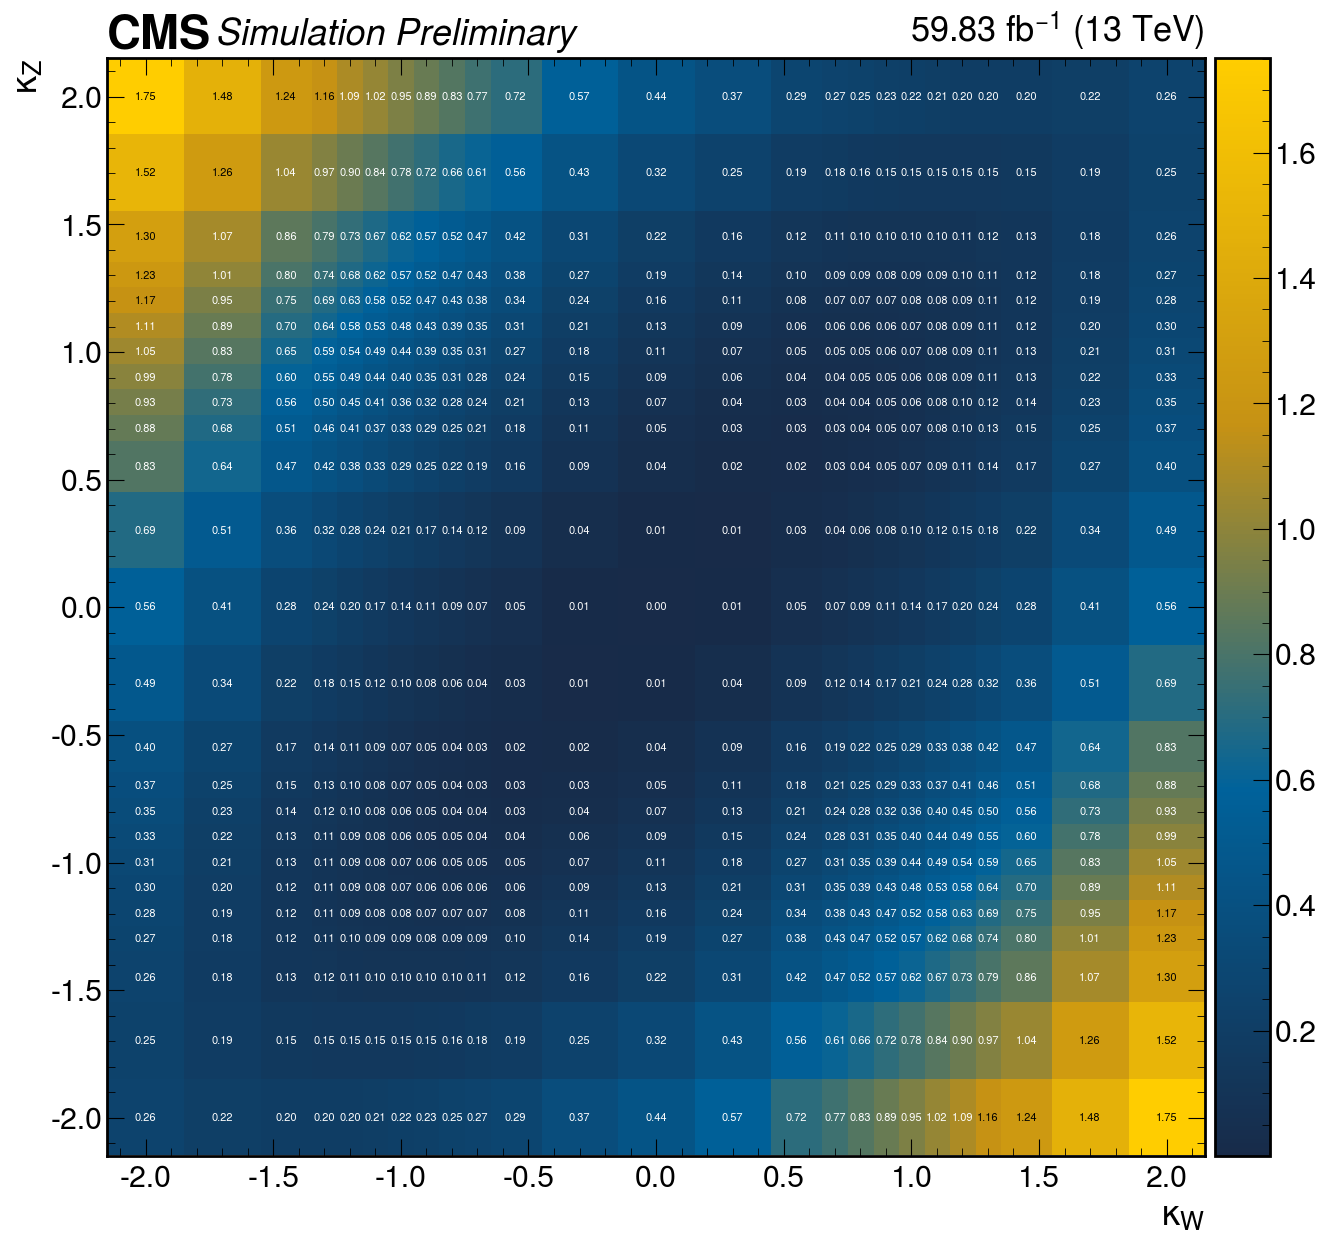

In [15]:
hist2d = yahist.Hist2D(
    (kW_points, kZ_points),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=np.array(xsecs)
)

# Plot 2D hist
fig, axes = plt.subplots(figsize=(15, 15))
mpl_objs = hist2d.plot(
    ax=axes, colorbar=False, counts=True, counts_formatter="{:.2f}".format, counts_fontsize=8, cmap=cmap
);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
colorbar(mpl_objs[0]);

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=neg_finfo["lumi"],
    loc=0,
    ax=axes,
#     fontsize=24
);

In [10]:
def plot_xsec_slice(kW, kZ, transpose=False):
    global hist2d
    global kW_values
    global kZ_values
    
    parabola = lambda x, A, B: A*x**2 + B
    
    fig, axes = plt.subplots()
    if transpose:
        # Get yields
        sig_yields = hist2d.counts.T[np.where(kW_values == kW)[0][0]]
        # Plot good yields
        axes.scatter(kZ_values[kZ_values != kZ], sig_yields[kZ_values != kZ]);
        # Plot bad yield
        axes.scatter(kZ_values[kZ_values == kZ], sig_yields[kZ_values == kZ]);
        
        # Fit good yields
        opt_params, _ = curve_fit(parabola, kZ_values[kZ_values != kZ], sig_yields[kZ_values != kZ])
        # Plot fit
#         axes.plot(np.linspace(-2, 2, 201), [parabola(x, *opt_params) for x in np.linspace(-2, 2, 201)])
        
        axes.set_xlabel(r"$\kappa_Z$");
        axes.set_title(r"$\kappa_W = NUMBER$".replace("NUMBER", str(kW)));
    else:
        # Get yields
        sig_yields = hist2d.counts[np.where(kZ_values == kZ)[0][0]]
        # Plot good yields
        axes.scatter(kW_values[kW_values != kW], sig_yields[kW_values != kW]);
        # Plot bad yields
        axes.scatter(kW_values[kW_values == kW], sig_yields[kW_values == kW]);

        # Fit good yields
        opt_params, _ = curve_fit(parabola, kW_values[kW_values != kW], sig_yields[kW_values != kW])
        # Plot fit
#         axes.plot(np.linspace(-2, 2, 201), [parabola(x, *opt_params) for x in np.linspace(-2, 2, 201)])
        
        axes.set_xlabel(r"$\kappa_W$");
        axes.set_title(r"$\kappa_Z = NUMBER$".replace("NUMBER", str(kZ)));
        
    axes.set_ylabel(r"$\sigma$ [pb]");

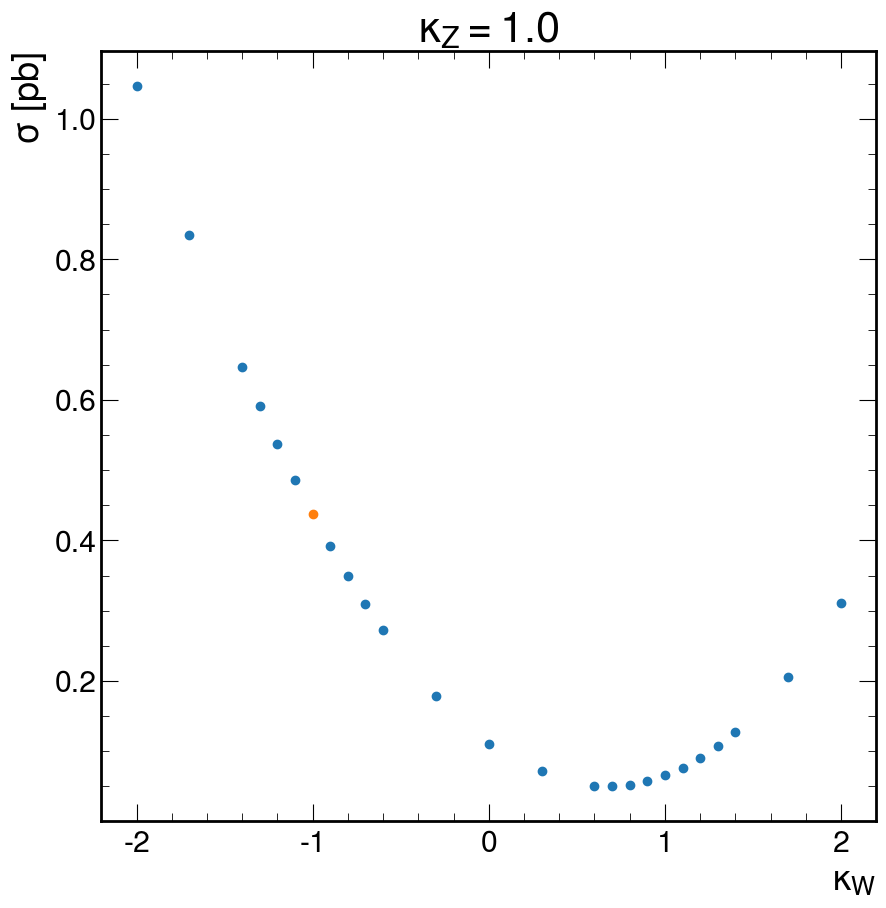

In [11]:
plot_xsec_slice(-1.0, 1.0)

In [10]:
def plot_xsecs(kW_eq_1=False):
    if kW_eq_1:
        key = "kW_1p0"
        kappa = r"\kappa_Z"
        fit_guess = [1, 1, 0.145]
    else:
        key = "kZ_1p0"
        kappa = r"\kappa_W"
        fit_guess = [1, 1, 0.108]
    
    kappas = []
    xsecs = []
    for reweight_i in range(neg_reweights.T.shape[0]):
        reweight_name = neg_reweight_names[reweight_i]
        if key not in reweight_name:
            continue

        xsec = neg_finfo["xsec_sf"]*np.sum(neg_reweights.T[reweight_i])/(1000*neg_finfo["lumi"])
        xsecs.append(xsec)
        
        other_key = list(filter(None, reweight_name.replace(key, "").split("_")))[-1]
        kappas.append(float(other_key.replace("m", "-").replace("p", ".")))

    for reweight_i in range(pos_reweights.T.shape[0]):
        reweight_name = pos_reweight_names[reweight_i]
        if key not in reweight_name:
            continue

        xsec = pos_finfo["xsec_sf"]*np.sum(pos_reweights.T[reweight_i])/(1000*pos_finfo["lumi"])
        xsecs.append(xsec)
        
        other_key = list(filter(None, reweight_name.replace(key, "").split("_")))[-1]
        kappas.append(float(other_key.replace("m", "-").replace("p", ".")))
        
    # Perform fit
    parabola = lambda x, A, B, C: A*x**2 + B*x + C
    opt_params, _ = curve_fit(parabola, kappas, xsecs, p0=fit_guess)
    A, B, C = opt_params

    # Plot fit and points
    fig, axes = plt.subplots();
    axes.plot(
        kappas, xsecs, 
        "ko", label=r"Reweighted $\sigma$", zorder=100
    );
    axes.plot(
        np.linspace(-3, 3, 31), [parabola(x, A, B, C) for x in np.linspace(-3, 3, 31)], 
        color="#364b9a",
        label=(r"$AK^2 BK C$".replace("A", f"{A:0.3f}")
                             .replace("B", f"{B:+0.3f}")
                             .replace("C", f"{C:+0.3f}")
                             .replace("K", kappa))
    );
    axes.legend();

    # Add CMS label
    hep.cms.label(
        "Preliminary",
        data=False,
        lumi=neg_finfo["lumi"],
        loc=0,
        ax=axes,
    )

    axes.set_ylim([0, 2]);
    axes.set_xlabel(f"${kappa}$");
    axes.set_ylabel(r"$\sigma$ [pb]");

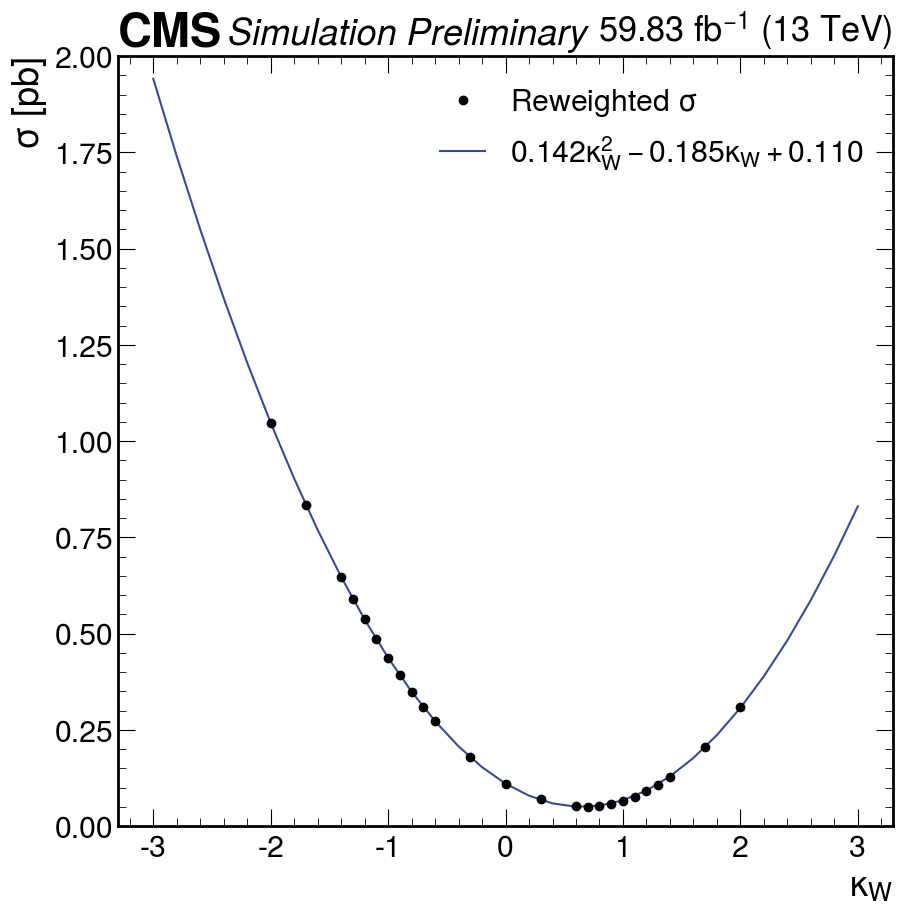

In [11]:
plot_xsecs(kW_eq_1=False)

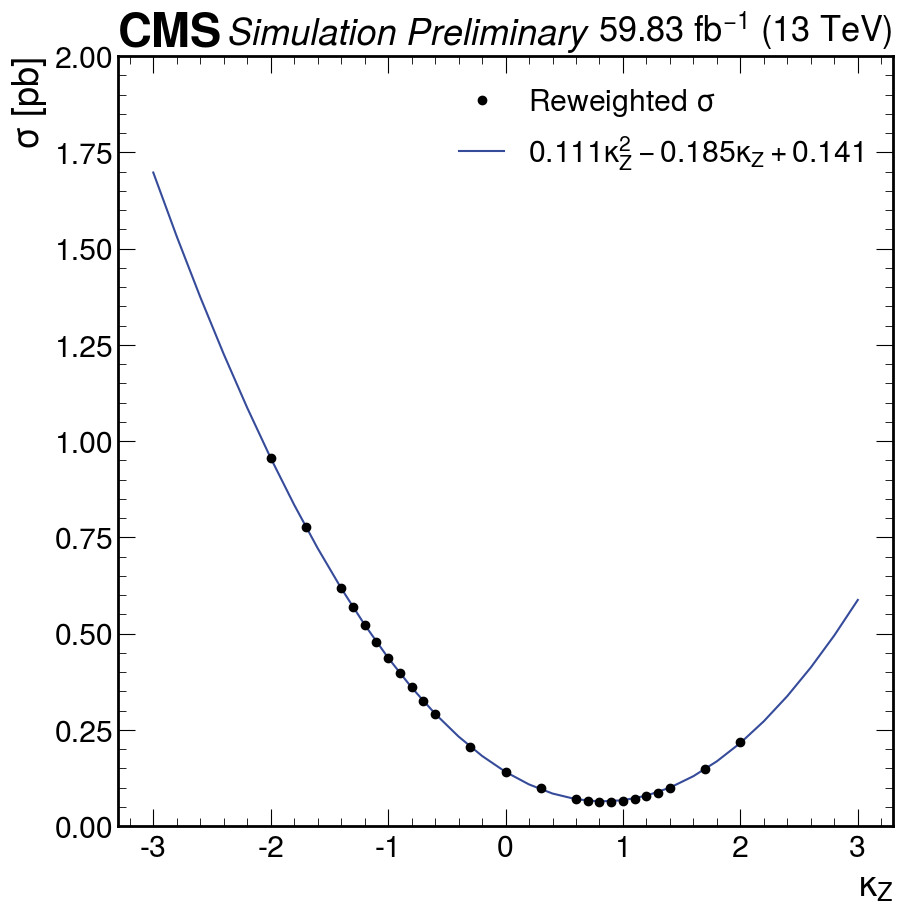

In [12]:
plot_xsecs(kW_eq_1=True)